In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle
import inspect
import itertools

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt

from astropy.table import Table, Column, vstack, join

## $\Delta\Sigma$ Profiles from Simulations

- Using `MDPL2` and `SMDPL` simulation and the mock model, we can predict the $\Delta\Sigma$ profiles of massive halos in each of our cumulative number density bins selected at given scatter value ($\sigma_{M_{\rm Halo}}$). We can compare them with the observed $\Delta\Sigma$ profiles later.

- We also get the halo mass distributions for these selections. 

- The reason we need both `MDPL2` and `SDMPL` is because we need:
    - `MDPL2` with large volumes to sample the high-mass end of halo mass function well. 
    - `SMDPL` with higher resolution to include lower mass halos when the scatter value is high

- By default, we include all galaxies (both central + satellites). For these N-body simulations, it means we include sub-halos if they could contain massive enough galaxies.
    - For cluster catalogs, we use the results from `MDPL2` simulation with just the central galaxies as well.

In [2]:
import jianbing

In [7]:
data_dir = os.path.join(
    os.path.dirname(os.path.dirname(jianbing.__file__)), 'data', 'simulation')

### Pre-computed DSigma profiles of galaxies from simulations

- This work is done by Christopher Bradshaw using the [`awesomefinder` code](https://github.com/dr-guangtou/awesome_cluster_finder) he developed. 
    - The code is currently maintained by Song Huang, and will be made public later.
- We use `halotools` to calculate the $\Delta\Sigma$ profiles.

In [60]:
# MDPL2 Cen + Sat galaxies
mdpl2_dsig_all = pickle.load(
    open(os.path.join(data_dir, 'mdpl2_dsigma_all.pickle'), "rb"))

# MDPL2 Cen only
mdpl2_dsig_cen = pickle.load(
    open(os.path.join(data_dir, 'mdpl2_dsigma_cen.pickle'), "rb"))

# SMDPL Cen + Sat galaxies
smdpl_dsig_all = pickle.load(
    open(os.path.join(data_dir, 'smdpl_dsigma_all.pickle'), "rb"))

- Convert the data structure into `astropy` table

In [61]:
mdpl2_all = Table(mdpl2_dsig_all)
mdpl2_all.rename_column('r', 'r_mpc')
mdpl2_all.rename_column('ds', 'dsig')
mdpl2_all.rename_column('ds_err', 'dsig_err')
mdpl2_all.rename_column('number_density_bin', 'bin')
mdpl2_all.rename_column('sim_n_lower', 'rank_low')
mdpl2_all.rename_column('sim_n_upper', 'rank_upp')
mdpl2_all['simulation'] = ['mdpl2'] * len(mdpl2_all)

In [62]:
smdpl_all = Table(smdpl_dsig_all)
smdpl_all.rename_column('r', 'r_mpc')
smdpl_all.rename_column('ds', 'dsig')
smdpl_all.rename_column('ds_err', 'dsig_err')
smdpl_all.rename_column('number_density_bin', 'bin')
smdpl_all.rename_column('sim_n_lower', 'rank_low')
smdpl_all.rename_column('sim_n_upper', 'rank_upp')
smdpl_all['simulation'] = ['smdpl'] * len(smdpl_all)

In [63]:
mdpl2_cen = Table(mdpl2_dsig_cen)
mdpl2_cen.rename_column('r', 'r_mpc')
mdpl2_cen.rename_column('ds', 'dsig')
mdpl2_cen.rename_column('ds_err', 'dsig_err')
mdpl2_cen.rename_column('number_density_bin', 'bin')
mdpl2_cen.rename_column('sim_n_lower', 'rank_low')
mdpl2_cen.rename_column('sim_n_upper', 'rank_upp')
mdpl2_cen['simulation'] = ['mdpl2'] * len(mdpl2_cen)

- Display the overlapping regions of scatter values between `MDPL2` and `SMDPL`

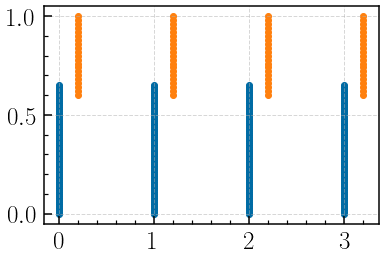

In [64]:
plt.scatter(mdpl2_all['bin'], mdpl2_all['scatter'])
plt.scatter(smdpl_all['bin'] + 0.2, smdpl_all['scatter'])

- Demo to show the ratio between $\Delta\Sigma$ profiles using Cen+Sat and Cen-only galaxies

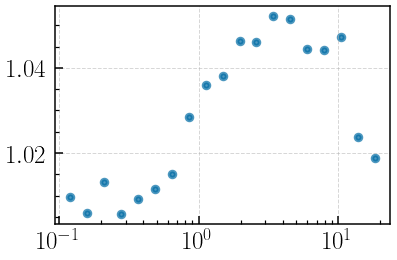

In [68]:
all_test = mdpl2_all[(mdpl2_all['bin'] == 1) & (mdpl2_all['scatter'] == 0.22)]
cen_test = mdpl2_cen[(mdpl2_cen['bin'] == 1) & (mdpl2_cen['scatter'] == 0.22)]

plt.xscale('log')
plt.scatter(
    all_test['r_mpc'], all_test['dsig'] / cen_test['dsig'], alpha=0.7, linewidth=3.5, rasterized=True)

### Save the results as FITS files

- Also combine the `MDPL2` and `SMDPL` tables

In [72]:
mdpl2_cen.write(
    os.path.join(data_dir, 'sim_mdpl2_cen_dsig.fits'), overwrite=True)

In [70]:
sim_merge_all_dsig = vstack(
    [mdpl2_all[mdpl2_all['scatter'] < 0.65], smdpl_all[smdpl_all['scatter'] >= 0.65]])

sim_merge_all_dsig.write(
    os.path.join(data_dir, 'sim_merge_all_dsig.fits'), overwrite=True)

In [71]:
sim_both_all_dsig = vstack([mdpl2_all, smdpl_all])

sim_both_all_dsig.write(
    os.path.join(data_dir, 'sim_both_all_dsig.fits'), overwrite=True)